<a href="https://colab.research.google.com/github/jaindevshrut/DL/blob/main/U23AI068_DL_LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=1000, shuffle=False, num_workers=2)

print("Trainset: "+str(len(trainset)))
print("Testset: "+str(len(testset)))

classes = ('0','1','2','3','4','5','6','7','8','9')

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.45MB/s]

Trainset: 60000
Testset: 10000


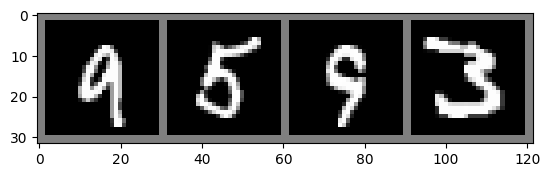

9     5     9     3    


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
def get_activation(name):
    if name == 'sigmoid': return nn.Sigmoid()
    if name == 'tanh': return nn.Tanh()
    return nn.ReLU()

In [ ]:
class FlexibleCNN(nn.Module):
    def __init__(self, activation_name='relu', use_bn=False, dropout_rate=0.25):
        super(FlexibleCNN, self).__init__()

        self.act_fn = get_activation(activation_name)
        self.use_bn = use_bn

        # Conv Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()

        # Conv Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

        self.fc1 = nn.Linear(12*12*64, 128)
        self.bn3 = nn.BatchNorm1d(128) if use_bn else nn.Identity()

        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act_fn(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act_fn(x)

        # Pooling & Regularization
        x = self.pool(x)
        x = self.dropout(x)

        # Dense Block
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.act_fn(x)

        # Output
        x = self.fc2(x)

        return x

In [ ]:
class FlexibleMLP(nn.Module):
    def __init__(self, layer_sizes, activation_name='relu', use_bn=True, dropout_rate=0.0):
        super(FlexibleMLP, self).__init__()
        layers = []
        input_dim = 784

        for hidden_dim in layer_sizes:
            layers.append(nn.Linear(input_dim, hidden_dim))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(get_activation(activation_name))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 10))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.network(x)
        return x

In [ ]:
def run_experiment(model_type, params, label="Experiment"):
    print(f"Running: {label}...")

    if model_type == 'CNN':
        model = FlexibleCNN(
            activation_name=params.get('act', 'relu'),
            use_bn=params.get('use_bn', False),
            dropout_rate=params.get('drop', 0.25)
        )
    else:
        model = FlexibleMLP(
            layer_sizes=params.get('layers', [256]),
            activation_name=params.get('act', 'relu'),
            use_bn=params.get('use_bn', True),
            dropout_rate=params.get('drop', 0.0)
        )

    opt_name = params.get('opt', 'adam')
    if opt_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif opt_name == 'sgd_momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    criterion = nn.CrossEntropyLoss()

    history = []
    epochs = params.get('epochs', 10)

    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            out = model(images)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        history.append(epoch_loss / len(train_loader))

    return history

In [ ]:
def plot_task(results, title):
    plt.figure(figsize=(10, 5))
    for name, hist in results.items():
        plt.plot(hist, label=name)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
results_t1 = {}
activations = ['sigmoid', 'tanh', 'relu']

for act in activations:
    results_t1[act] = run_experiment(
        'CNN',
        {'act': act, 'opt': 'adam', 'use_bn': False, 'drop': 0.0},
        label=f"Task 1 - {act}"
    )

plot_task(results_t1, "Task 1: Activation Functions (CNN)")

In [ ]:
results_t2 = {}
optimizers = ['sgd', 'sgd_momentum', 'adam']

for opt in optimizers:
    results_t2[opt] = run_experiment(
        'CNN',
        {'act': 'relu', 'opt': opt, 'use_bn': False, 'drop': 0.0},
        label=f"Task 2 - {opt}"
    )

plot_task(results_t2, "Task 2: Optimizers (CNN with ReLU)")

In [ ]:
results_t3 = {}

results_t3['No BN, No Drop'] = run_experiment(
    'CNN',
    {'act': 'relu', 'opt': 'adam', 'use_bn': False, 'drop': 0.0},
    label="Task 3 - Base"
)

results_t3['No BN, Drop=0.1'] = run_experiment(
    'CNN',
    {'act': 'relu', 'opt': 'adam', 'use_bn': False, 'drop': 0.1},
    label="Task 3 - Drop 0.1"
)

results_t3['BN + Drop=0.25'] = run_experiment(
    'CNN',
    {'act': 'relu', 'opt': 'adam', 'use_bn': True, 'drop': 0.25},
    label="Task 3 - BN + Drop 0.25"
)

plot_task(results_t3, "Task 3: Regularization (CNN)")